# Deep neural networks

This notebook shows how to build and train a neural network with plain numpy before and with pytorch lightning after.

## Numpy

In [1]:
import numpy as np

Let's create a neural network

In [2]:
# Define the Rectified Linear Unit (ReLU) function
def ReLU(preactivation):
    activation = preactivation.clip(0.0)
    return activation

# Define a function to generate a neural network
def NN(layers):

    assert len(layers) > 2  # We should at least have input, output and one hidden layer for an MLP

    weights = []
    biases = []

    for i in range(1, len(layers)):

        # Weight matrix for layer i has dimension (layers[i], layers[i - 1])
        # (n_neurons_current_layer, n_neurons_previous_layer)
        W = np.random.randn(layers[i], layers[i - 1])

        # Bias vector for layer i has dimension (layers[i], 1)
        b = np.random.randn(layers[i], 1)

        weights.append(W)
        biases.append(b)

    return weights, biases

layers = [3, 4, 2, 3, 2]
weights, biases = NN(layers)

print(f'Weight matrices shapes: {[w.shape for w in weights]}')
print(f'Bias vectors shapes   : {[b.shape for b in biases]}')
print()

for i in range(len(layers) - 1):
    print(f'Layer: {i}')
    print(f'Weights:\n{weights[i]}')
    print(f'Biases:\n{biases[i]}')
    print()

Weight matrices shapes: [(4, 3), (2, 4), (3, 2), (2, 3)]
Bias vectors shapes   : [(4, 1), (2, 1), (3, 1), (2, 1)]

Layer: 0
Weights:
[[ 0.15878967 -1.43167153  0.48100721]
 [-1.61972012 -1.60996653  0.68520744]
 [ 0.44251945 -0.68429073 -0.06136297]
 [-1.40746582  1.12815022  0.8707997 ]]
Biases:
[[ 2.01444419]
 [-0.95144809]
 [ 1.07564006]
 [ 1.11974775]]

Layer: 1
Weights:
[[-1.71678368 -1.08228681 -0.46881637  0.64787858]
 [ 0.59733148  1.42811471  0.45216792  0.2670955 ]]
Biases:
[[0.37329649]
 [1.13124374]]

Layer: 2
Weights:
[[ 0.4340502  -0.5212211 ]
 [ 0.11447428 -0.72734834]
 [ 0.09504607  1.66083435]]
Biases:
[[ 0.64818036]
 [ 0.15356417]
 [-0.5132458 ]]

Layer: 3
Weights:
[[ 0.36341437 -0.21006353 -0.10474447]
 [ 0.66474634  2.28531858  0.69291336]]
Biases:
[[0.24056964]
 [0.65029579]]



Visualize it

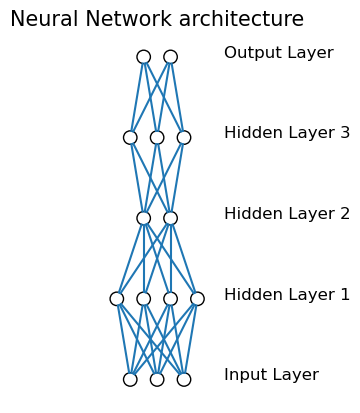

In [3]:
import matplotlib.pyplot as plt
from math import cos, sin, atan

def draw_neuron(x, y, neuron_radius):
    circle = plt.Circle((x, y), radius=neuron_radius, fill=False)
    plt.gca().add_patch(circle)

def line_between_two_neurons(neuron1, neuron2, neuron_radius):
    angle = atan((neuron2[0] - neuron1[0]) / float(neuron2[1] - neuron1[1]))
    x_adjustment = neuron_radius * sin(angle)
    y_adjustment = neuron_radius * cos(angle)
    line = plt.Line2D(
        (neuron1[0] - x_adjustment, neuron2[0] + x_adjustment),
        (neuron1[1] - y_adjustment, neuron2[1] + y_adjustment)
    )
    plt.gca().add_line(line)

def calculate_layer_y_position(previous_layer_y, vertical_distance):
    return previous_layer_y + vertical_distance if previous_layer_y is not None else 0

def calculate_left_margin_so_layer_is_centered(number_of_neurons, widest_layer, horizontal_distance):
    return horizontal_distance * (widest_layer - number_of_neurons) / 2

def initialize_neurons(number_of_neurons, y, left_margin, horizontal_distance):
    neurons = []
    x = left_margin
    for _ in range(number_of_neurons):
        neurons.append((x, y))
        x += horizontal_distance
    return neurons

def draw_layer(neurons, previous_layer_neurons, neuron_radius, layer_type, widest_layer, horizontal_distance, y):
    # Draw neurons and lines between neurons
    for neuron in neurons:
        draw_neuron(neuron[0], neuron[1], neuron_radius)
        if previous_layer_neurons:
            for prev_neuron in previous_layer_neurons:
                line_between_two_neurons(neuron, prev_neuron, neuron_radius)
    # Add layer text
    x_text = widest_layer * horizontal_distance
    if layer_type == 0:
        plt.text(x_text, y, 'Input Layer', fontsize=12)
    elif layer_type == -1:
        plt.text(x_text, y, 'Output Layer', fontsize=12)
    else:
        plt.text(x_text, y, f'Hidden Layer {layer_type}', fontsize=12)

def draw_network(layers, vertical_distance_between_layers=6, horizontal_distance_between_neurons=2, neuron_radius=0.5):
    plt.figure()
    widest_layer = max(layers)
    previous_layer_neurons = None
    y = None
    for i, number_of_neurons in enumerate(layers):
        y = calculate_layer_y_position(y, vertical_distance_between_layers)
        left_margin = calculate_left_margin_so_layer_is_centered(
            number_of_neurons, widest_layer, horizontal_distance_between_neurons)
        neurons = initialize_neurons(number_of_neurons, y, left_margin, horizontal_distance_between_neurons)
        
        layer_type = i if i < len(layers) - 1 else -1
        draw_layer(neurons, previous_layer_neurons, neuron_radius, layer_type, widest_layer, horizontal_distance_between_neurons, y)
        previous_layer_neurons = neurons

    plt.axis('scaled')
    plt.axis('off')
    plt.title('Neural Network architecture', fontsize=15)
    plt.show()

draw_network(layers)

Forward pass

In [4]:
# Input to the network
X = np.random.randn(layers[0], 1) 

A = X
for W, b in zip(weights, biases):
    
    # Z = W * A + b
    Z = np.dot(W, A) + b

    # Apply activation function (ReLU in this case)
    A = ReLU(Z)

print('Output:')
print(A)

Output:
[[0.        ]
 [4.37935292]]


# Pytorch

In [5]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

### Iris Dataset Example

In [6]:
from sklearn.datasets import load_iris

data = load_iris()
print(data.DESCR[60:1210])


**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Creator: R.A. Fisher
:Donor: Michael Marshall (MARSHALL%PLU@io

In [7]:
class IrisDataset(torch.utils.data.Dataset):

    def __init__(self):
        X, y = load_iris(return_X_y=True)
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y)

    def __getitem__(self, index):
        x = self.X[index]
        y = self.y[index]
        return x, y

    def __len__(self):
        return len(self.X)

iris_dataset = IrisDataset()

# Get train. validation and test sets
length = len(iris_dataset)
train_len = int(length * 0.7)
val_len = int(length * 0.2 )
test_len = length - train_len - val_len

iris_train_dataset, iris_val_dataset, iris_test_dataset = \
torch.utils.data.random_split(iris_dataset, [train_len, val_len, test_len])

print(f'Validation set samples: {len(iris_val_dataset)}')
print(f'Train set samples: {len(iris_train_dataset)}')
print(f'Test set samples: {len(iris_test_dataset)}')

iris_train_loader = DataLoader(iris_train_dataset, batch_size=8, shuffle=True)
iris_val_loader = DataLoader(iris_val_dataset, batch_size=8)
iris_test_loader = DataLoader(iris_test_dataset, batch_size=8)

Validation set samples: 30
Train set samples: 105
Test set samples: 15


Show what the dataset contains

In [8]:
# Iterate the batches
for x_batch, y_batch in iris_test_loader:
    
    print('Sample batch')
    print(x_batch)
    print('Label batch')
    print(y_batch)
    print()

    # A batch is simply a tensor. The first dimension of the tensor 
    # groups different samples
    first_sample = x_batch[0]
    first_label = y_batch[0]
    
    print('First sample:')
    print(first_sample)
    print('First label:')
    print(first_label)

    break

Sample batch
tensor([[5.0000, 3.6000, 1.4000, 0.2000],
        [7.2000, 3.0000, 5.8000, 1.6000],
        [6.3000, 2.3000, 4.4000, 1.3000],
        [5.1000, 3.5000, 1.4000, 0.2000],
        [5.0000, 3.5000, 1.3000, 0.3000],
        [6.4000, 3.2000, 4.5000, 1.5000],
        [4.5000, 2.3000, 1.3000, 0.3000],
        [5.0000, 2.0000, 3.5000, 1.0000]])
Label batch
tensor([0, 2, 1, 0, 0, 1, 0, 1])

First sample:
tensor([5.0000, 3.6000, 1.4000, 0.2000])
First label:
tensor(0)


In Torch we need to specify the device where the tensors live

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cpu'

Create a model to work with the Iris Dataset

In [10]:
class TorchModel(nn.Module):

    def __init__(self, layers):
        super(TorchModel, self).__init__()

        # Store the size of each layer just for visualization purposes
        self.layer_sizes = [l for l in layers]
 
        # Create a list to hold all the layers
        self.layers = nn.ModuleList()

        # Loop through layers and create the respective modules
        for i in range(1, len(layers)):

            # Note the sizes are reversed:
            # Numpy ->  (n_neurons_current_layer, n_neurons_previous_layer)
            #           this is due to the matrix multiplication W x + b
            #           W has size (n_neurons_current_layer, n_neurons_previous_layer)
            # Torch ->  nn.Lienar(in_features, out_features) expects the opposite
            self.layers.append(nn.Linear(layers[i - 1], layers[i]))

        self.activation_function = nn.ReLU()

    def forward(self, x):

        # Pass through each layer except the last one with ReLU activation
        for i in range(len(self.layers) - 1):
            x = self.activation_function(self.layers[i](x))
        
        # No activation for the last layer if it's for regression or classification logits
        x = self.layers[-1](x)
        return x

# We will use the same network architecture as before (numpy) except for the input and the output
model = TorchModel([4] + layers[1:-1] + [3])
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1)

print(f'Layers: {model.layer_sizes}')
print(model)

Layers: [4, 4, 2, 3, 3]
TorchModel(
  (layers): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=True)
    (1): Linear(in_features=4, out_features=2, bias=True)
    (2): Linear(in_features=2, out_features=3, bias=True)
    (3): Linear(in_features=3, out_features=3, bias=True)
  )
  (activation_function): ReLU()
)


Forward pass

In [11]:
model(torch.randn(1, 4))

tensor([[-0.2169, -0.2886, -0.2400]], grad_fn=<AddmmBackward0>)

Perform the training

In [12]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()  # Set the model to training mode
    total_loss, correct = 0, 0
    total_samples = len(dataloader.dataset)

    progress_bar = tqdm(dataloader, desc="Training", leave=True)
    for batch, (X, y) in enumerate(progress_bar):
        X, y = X.to(device), y.to(device)
        
        # Forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track loss
        total_loss += loss.item()

        # Track accuracy
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # Update progress bar
        progress_bar.set_postfix({'loss': loss.item()})
    
    avg_loss = total_loss / total_samples
    accuracy = correct / total_samples

    return avg_loss, accuracy

epochs = 5
for t in range(epochs):

    print(f"-------------------------------")
    print(f"Epoch {t+1}")
    avg_loss, avg_acc = train(iris_train_loader, model, loss_fn, optimizer)
    print(f"Train Loss: {avg_loss:.4f}, Train Accuracy: {avg_acc:.4f}")

-------------------------------
Epoch 1


Training: 100%|██████████| 14/14 [00:00<00:00, 235.34it/s, loss=1.13]


Train Loss: 0.1481, Train Accuracy: 0.3143
-------------------------------
Epoch 2


Training: 100%|██████████| 14/14 [00:00<00:00, 313.16it/s, loss=1.2]


Train Loss: 0.1485, Train Accuracy: 0.3238
-------------------------------
Epoch 3


Training: 100%|██████████| 14/14 [00:00<00:00, 403.94it/s, loss=1.24]


Train Loss: 0.1477, Train Accuracy: 0.3619
-------------------------------
Epoch 4


Training: 100%|██████████| 14/14 [00:00<00:00, 383.18it/s, loss=1.13]


Train Loss: 0.1465, Train Accuracy: 0.3619
-------------------------------
Epoch 5


Training: 100%|██████████| 14/14 [00:00<00:00, 467.96it/s, loss=1.12]

Train Loss: 0.1468, Train Accuracy: 0.3333


Now that the model is trained, we can test it and perform inference

In [13]:
def test(dataloader, model, loss_fn):
    model.eval()  # Put the model in evaluation mode
    total_loss, correct = 0, 0
    total_samples = len(dataloader.dataset)

    with torch.no_grad():  # Disable gradient calculation for inference
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            # Make predictions
            pred = model(X)
            
            # Calculate loss
            total_loss += loss_fn(pred, y).item()
            
            # Calculate number of correct predictions
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    avg_loss = total_loss / total_samples
    accuracy = correct / total_samples
    return avg_loss, accuracy

test_loss, test_acc = test(iris_test_loader, model, loss_fn)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.1467, Test Accuracy: 0.2667


In [14]:
X, y = iris_test_dataset[0]

print('Input:')
print(X)
print('Ground truth:')
print(y.item())
print('Prediction:')
print(torch.argmax(model(X)).item())

Input:
tensor([5.0000, 3.6000, 1.4000, 0.2000])
Ground truth:
0
Prediction:
2


### MNIST Dataset Example

In [15]:
from pathlib import Path

folder_name = "data/MNIST"

# Get the current directory where the notebook is located
current_directory = Path.cwd()

# Create the full path for the new folder
new_folder_path = current_directory / folder_name

# Create the folder (if it doesn't already exist)
new_folder_path.mkdir(parents=True, exist_ok=True)

print(f"Folder '{folder_name}' created at: {new_folder_path}")


Folder 'data/MNIST' created at: /home/daniel/Git/Deep-Learning/notebooks/personal/data/MNIST


In [16]:
from torchvision.datasets import MNIST
from torchvision import transforms
from pathlib import Path


# Create a folder to store the data
folder_name = "data"
current_directory = Path.cwd()
data_path = current_directory / folder_name
data_path.mkdir(parents=True, exist_ok=True) 

# Load the MNIST dataset
train_ds = MNIST(data_path, train=True, download=True, transform=transforms.ToTensor())
test_ds = MNIST(data_path, train=False, download=True, transform=transforms.ToTensor())

# Add a .gitignore file to the folder to avoid tracking it
gitignore_path = folder_name / Path('.gitignore')
with gitignore_path.open('w') as gitignore_file:
    gitignore_file.write('*\n')  # This ignores everything in the folder

# Define lengths for train and validation sets
train_len = int(len(train_ds) * 0.8)  # 80% for training
val_len = len(train_ds) - train_len    # Remaining 20% for validation

# Split the dataset into training and validation sets
train_subset, val_subset = \
    torch.utils.data.random_split(train_ds, [train_len, val_len])

# Each image in the dataset has an extra dimension
# Image size = 1, 8, 8
# We want to have a 8x8 image

def custom_collate(batch):

    # Here batch is a tuple containing two tensors (image, label)
    # For each tensor, the first dimension is the batch size
    # Flatten the images such to obtain an array with size (batch_size, width * height)
    images = [t[0].reshape(-1) for t in batch]
    labels = [t[1] for t in batch]

    # Squeeze each image tensor to remove the second dimension
    return torch.stack(images), torch.tensor(labels)

# Create DataLoaders
mnist_train_loader = DataLoader(train_subset, batch_size=8, shuffle=True, collate_fn=custom_collate, num_workers=4)
mnist_val_loader = DataLoader(val_subset, batch_size=8, collate_fn=custom_collate, num_workers=4)
mnist_test_loader = DataLoader(test_ds, batch_size=8, collate_fn=custom_collate, num_workers=4)

# Print the sizes of the datasets
print(f'Validation set samples: {len(iris_val_dataset)}')
print(f'Train set samples: {len(iris_train_dataset)}')
print(f'Test set samples: {len(iris_test_dataset)}')

Validation set samples: 30
Train set samples: 105
Test set samples: 15


In [17]:
# Iterate the batches
for x_batch, y_batch in mnist_test_loader:
    
    print(f'Sample batch shape: {x_batch.shape}')
    print(f'Label batch shape : {y_batch.shape}')
    print()

    # A batch is simply a tensor. The first dimension of the tensor 
    # groups different samples
    first_sample = x_batch[0]
    first_label = y_batch[0]
    
    print(f'First sample shape: {first_sample.shape}')
    print(f'First label shape : {first_label.shape}')  # This is just an integer

    break

Sample batch shape: torch.Size([8, 784])
Label batch shape : torch.Size([8])

First sample shape: torch.Size([784])
First label shape : torch.Size([])


In [18]:
# Get the size of a sample
X_sample, y_sample = test_ds[0]
sample_width, sample_height = X_sample.shape[1], X_sample.shape[2]
input_layer_size = sample_width * sample_height
output_layer_size = 10

print(f'Input layer size : {input_layer_size}')
print(f'Output layer size: {output_layer_size}')

layers = [input_layer_size] + [100, 50, 20] + [output_layer_size]
print(f'Layers: {model.layer_sizes}')

Input layer size : 784
Output layer size: 10
Layers: [4, 4, 2, 3, 3]


In [19]:
# Use a different structure as the input is higher-dimensional
model = TorchModel(layers)
loss_fn = nn.CrossEntropyLoss()  # MNIST is classification too
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1)

print(model)

TorchModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=10, bias=True)
  )
  (activation_function): ReLU()
)


In [20]:
epochs = 5
for t in range(epochs):

    print(f"-------------------------------")
    print(f"Epoch {t+1}")
    avg_loss, avg_acc = train(mnist_train_loader, model, loss_fn, optimizer)
    print(f"Train Loss: {avg_loss:.4f}, Train Accuracy: {avg_acc:.4f}")

-------------------------------
Epoch 1


Training: 100%|██████████| 6000/6000 [00:31<00:00, 191.91it/s, loss=0.514]   


Train Loss: 0.0831, Train Accuracy: 0.8232
-------------------------------
Epoch 2


Training: 100%|██████████| 6000/6000 [00:30<00:00, 198.84it/s, loss=0.411]   


Train Loss: 0.0638, Train Accuracy: 0.8778
-------------------------------
Epoch 3


Training: 100%|██████████| 6000/6000 [00:34<00:00, 175.48it/s, loss=0.515]   


Train Loss: 0.0618, Train Accuracy: 0.8783
-------------------------------
Epoch 4


Training: 100%|██████████| 6000/6000 [00:33<00:00, 178.75it/s, loss=1.03]    


Train Loss: 0.0940, Train Accuracy: 0.7446
-------------------------------
Epoch 5


Training: 100%|██████████| 6000/6000 [00:32<00:00, 182.86it/s, loss=0.583]   

Train Loss: 0.1015, Train Accuracy: 0.6994


In [21]:
test_loss, test_acc = test(mnist_test_loader, model, loss_fn)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.1034, Test Accuracy: 0.7008


Ground truth:
7
Prediction:
7


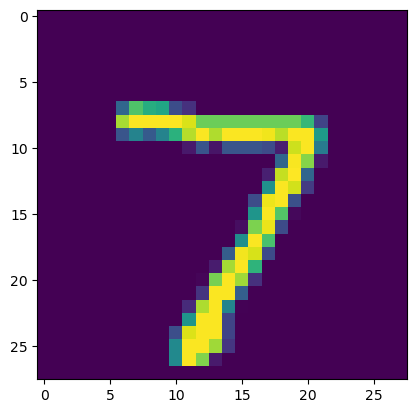

In [22]:
X, y = test_ds[0]

X_np = X.squeeze().numpy()

print('Ground truth:')
print(y)
print('Prediction:')
print(model(X.reshape(-1)).argmax().item())

plt.imshow(X_np)
plt.show()

## Pytorch Lightning

In [23]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger


We can do the same thing with Pytorch Lightning but in a much easier way

In [25]:
class LightningModel(pl.LightningModule):

    def __init__(self, layers):
        super().__init__()

        # Store the size of each layer just for visualization purposes
        self.layer_sizes = [l for l in layers]
 
        # Create a list to hold all the layers
        self.layers = nn.ModuleList()

        # Loop through layers and create the respective modules
        for i in range(1, len(layers)):

            # Note the sizes are reversed:
            # Numpy ->  (n_neurons_current_layer, n_neurons_previous_layer)
            #           this is due to the matrix multiplication W x + b
            #           W has size (n_neurons_current_layer, n_neurons_previous_layer)
            # Torch ->  nn.Lienar(in_features, out_features) expects the opposite
            self.layers.append(nn.Linear(layers[i - 1], layers[i]))

        self.activation_function = nn.ReLU()

    def forward(self, x):

        # Pass through each layer except the last one with ReLU activation
        for i in range(len(self.layers) - 1):
            x = self.activation_function(self.layers[i](x))
        
        # No activation for the last layer if it's for regression or classification logits
        x = self.layers[-1](x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        loss = F.cross_entropy(self(x), y)

        self.log('train_loss', loss, on_step=False, on_epoch=True)

        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        loss = F.cross_entropy(self(x), y)

        # Calculate accuracy
        preds = torch.argmax(self(x), dim=1)
        acc = torch.sum(preds == y).item() / y.size(0)

        # Log metrics
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True)

        return {'val_loss': loss, 'val_acc': acc}

    def test_step(self, batch, batch_idx):
        x, y = batch
        loss = F.cross_entropy(self(x), y)

        # Calculate accuracy
        preds = torch.argmax(self(x), dim=1)
        acc = torch.sum(preds == y).item() / y.size(0)

        # Log metrics
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        self.log('test_acc', acc, on_step=False, on_epoch=True)

        return {'test_loss': loss, 'test_acc': acc}

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

# Train model
model = LightningModel(layers)

# Log to tensorboard
logger = TensorBoardLogger("data/logs/", name="MNISTLightningFeedforward")

trainer = pl.Trainer(
    max_epochs=100,
    logger=logger,
    callbacks=[
        TQDMProgressBar(refresh_rate=20),
        EarlyStopping(monitor='val_loss', patience=5, mode='min')
    ]
)

trainer.fit(model, train_dataloaders=mnist_train_loader, val_dataloaders=mnist_val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs

  | Name                | Type       | Params
---------------------------------------------------
0 | layers              | ModuleList | 84.8 K
1 | activation_function | ReLU       | 0     
---------------------------------------------------
84.8 K    Trainable params
0         Non-trainable params
84.8 K    Total params
0.339     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [26]:
trainer.test(model, mnist_test_loader)

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.973800003528595
        test_loss           0.11605041474103928
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.11605041474103928, 'test_acc': 0.973800003528595}]

Let's change model. We will define and use an autoencoder to learn to reconstruct an image of the MNIST dataset from the latent space

In [32]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Sequential(nn.Linear(28 * 28, 64), nn.ReLU(), nn.Linear(64, 3))

    def forward(self, x):
        return self.l1(x)

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Sequential(nn.Linear(3, 64), nn.ReLU(), nn.Linear(64, 28 * 28))

    def forward(self, x):
        return self.l1(x)

class LightningAutoEncoder(pl.LightningModule):

    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def common_step(self, batch):
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self.common_step(batch)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss  # It's best to return the loss directly
    
    def test_step(self, batch, batch_idx):
        loss = self.common_step(batch)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        return {"test_loss": loss}

    def validation_step(self, batch, batch_idx):
        loss = self.common_step(batch)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return {"val_loss": loss}

    def predict_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

# The autoencoder's prediction will give the reconstructed images, which aligns with the 
# autoencoder's task
autoencoder = LightningAutoEncoder(Encoder(), Decoder())

logger = TensorBoardLogger("data/logs/", name="MNISTLightningAutoencoder")

# Train the model
trainer = pl.Trainer(
    max_epochs=100,
    logger=logger,
    callbacks=[
        TQDMProgressBar(refresh_rate=20),
        EarlyStopping(monitor='val_loss', patience=5, mode='min')
    ]
)
trainer.fit(autoencoder, train_dataloaders=mnist_train_loader, val_dataloaders=mnist_val_loader)

# Test the model
# trainer.test(autoencoder, dataloaders=mnist_test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 50.4 K
1 | decoder | Decoder | 51.2 K
------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.407     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

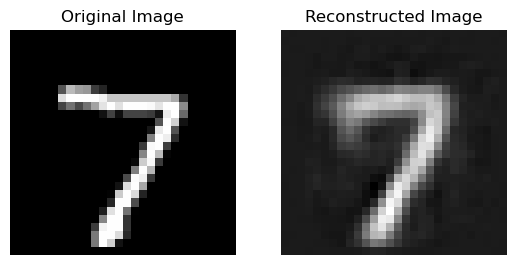

In [34]:
# Select an image from the test dataset (or any single image)
example_image, _ = next(iter(mnist_test_loader))  # Get a batch, but we take one image
example_image = example_image[0]  # Get the first image in the batch

# Reshape the image to match the input format of the model (flatten it)
input_image = example_image.view(1, -1)

# Move to device if you're using GPU
# input_image = input_image.to(autoencoder.device)

# Pass the image through the autoencoder
with torch.no_grad():
    reconstructed_image = autoencoder.encoder(input_image)
    reconstructed_image = autoencoder.decoder(reconstructed_image)

# Reshape the output back to 28x28 for visualization
reconstructed_image = reconstructed_image.view(28, 28).numpy()  # .cpu()

# Move the original image to CPU and detach it (if necessary)
# original_image = example_image.cpu().detach()
original_image = example_image.view(28, 28).numpy()

# Plot original and reconstructed images side by side
fig, axes = plt.subplots(1, 2)

# Plot original image
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

# Plot reconstructed image
axes[1].imshow(reconstructed_image, cmap='gray')
axes[1].set_title("Reconstructed Image")
axes[1].axis('off')

plt.show()